<a href="https://colab.research.google.com/github/kermityan/EPAM-DS-ML-Course-Notebooks/blob/main/NLP_Language_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced NLP HW0: Language modeling

Before starting the task please read thoroughly these chapters of Speech and Language Processing by Daniel Jurafsky & James H. Martin:

•	N-gram language models: https://web.stanford.edu/~jurafsky/slp3/3.pdf

•	Neural language models: https://web.stanford.edu/~jurafsky/slp3/7.pdf

In this task you will be asked to implement the models described there.

Build a text generator based on n-gram language model and neural language model.
1.	Find a corpus (e.g. http://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt ), but you are free to use anything else of your interest
2.	Preprocess it if necessary (we suggest using nltk for that)
3.	Build an n-gram model
4.	Try out different values of n, calculate perplexity on a held-out set
5.	Build a simple neural network model for text generation (start from a feed-forward net for example). We suggest using tensorflow + keras for this task

Criteria:
1.	Data is split into train / validation / test, motivation for the split method is given
2.	N-gram model is implemented
  *	Unknown words are handled
  * Add-k Smoothing is implemented
3.	Neural network for text generation is implemented
4.	Perplexity is calculated for both models
5.	Examples of texts generated with different models are present and compared
6.	Optional: Try both character-based and word-based approaches.

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 10.5 MB/s eta 0:00:00


In [ ]:
from typing import Iterable, Union, Tuple, List
import random
import math
from functools import wraps
from itertools import islice
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords

from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
from nltk.tokenize import word_tokenize
from nltk.util import pad_sequence

from sklearn.model_selection import train_test_split

import string
import re
from collections import Counter

import contractions


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

###Auxiliary functions

In [ ]:
def remove_punct(text):
  # Remove all punctuation signs from the given text
  return "".join([char if char not in string.punctuation else ' ' for char in text])

In [ ]:
def get_corpus_statistics(col, top_num=20, verbose=1):
  # Calculating the total number of words in the corpus and frequency of use for every word
  corpus = ""
  for text in col:
    if type(text)==list:
      text = ' '.join(text)
    corpus += text
    corpus += ' '
  words = remove_punct(corpus).lower().split()
  word_counts = Counter(words)

  voc_size = len(list(word_counts))
  result = {}
  if verbose!=0:
    print('Size of vocabulary: ', voc_size)
    print(f'Most {top_num} common words are:')
    for item in word_counts.most_common(top_num):
      result[item[0]] = int(item[1])
    print(result)
  return dict(word_counts), voc_size

Loading the data:

In [ ]:
corpus_path = '/content/Data/'
corpus_filename = 'corpus.txt'
full_path = corpus_path + corpus_filename

In [ ]:
import requests
import os
from pathlib import Path

#datadir = "Data"
if not os.path.isdir(corpus_path):
  os.mkdir(corpus_path)

if Path(full_path).is_file():
  print("corpus.txt already exists, skipping download")
else:
  print(f"Downloading {corpus_filename}")
  request = requests.get("http://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt")
  with open(full_path, "wb") as f:
    f.write(request.content)

In [ ]:
shaksp_corpus = PlaintextCorpusReader(corpus_path, '.*\.txt')

In [ ]:
shaksp_corpus.sents()

[['First', 'Citizen', ':', 'Before', 'we', 'proceed', 'any', 'further', ',', 'hear', 'me', 'speak', '.'], ['All', ':', 'Speak', ',', 'speak', '.'], ...]

In [ ]:
shaksp_corpus.words()

['First', 'Citizen', ':', 'Before', 'we', 'proceed', ...]

In [ ]:
tokens = shaksp_corpus.sents()

####Functions for preprocessing

In [ ]:
def text_clearning(text):
  text = str(text).lower()
  text = text[text.find(':')+1:] if text.find(':')!=-1 else text


  text = "".join([char if char not in string.punctuation else ' ' for char in text])
  text = " ".join(text.split())
  return text

In [ ]:
def restore_contractions(tokens):
  """
  Restore contractions - join tokens that are around ' into one for further processing
  """
  new_tokens = []
  for sent in tokens:

    to_delete=[]
    for i, word in enumerate(sent):
      #print(i, word)
      if word=="'":
        if i == 0:
          sent[i] = sent[i]+sent[i+1]
          to_delete.append(i+1)
        elif i == len(sent)-1:
          sent[i] = sent[i-1]+sent[i]
          to_delete.append(i-1)
        else:
          joined_word = sent[i-1]+sent[i]+sent[i+1]
          if joined_word in contractions.contractions_dict.keys():
            sent[i] = joined_word
            to_delete.append(i-1)
            to_delete.append(i+1)
          else:
            sent[i] = sent[i]+sent[i+1]
            to_delete.append(i+1)


    for i in sorted(to_delete, reverse=True):
      del sent[i]
    new_tokens.append(sent)
  return new_tokens

In [ ]:
tokens = restore_contractions(tokens)

In [ ]:
tokens[6]

['All', ':', 'We', 'know', "'t", ',', 'we', 'know', "'t", '.']

In [ ]:
add_contr = {
    "'ll": "will",
    "'re": "are",
    "'ve": "have",
    "'d": "would",
    "'t": "that",
    "'s": "is"
}

In [ ]:
def fix_contractions(tokens):
  """
  Replace constructions with full form
  """
  new_tokens = []
  unk_contractions = set()
  for sent in tokens:
    expanded_words = []
    for word in sent:
      if word[0] == "'" and word not in contractions.contractions_dict.keys():
        if word in add_contr.keys():
          expanded_words.append(add_contr[word])
        unk_contractions.add(word)
      else:
        expanded_words.append(contractions.fix(word))

    joined_string = ' '.join(expanded_words)

    new_tokens.append(joined_string.split())
  return new_tokens, unk_contractions


In [ ]:
tokens, unknown_contr = fix_contractions(tokens)

Removing punctuations and characters names in the corpus:

In [ ]:
for sent in tokens[:20]:
  print(text_clearning(' '.join(sent)))

before we proceed any further hear me speak
speak speak
you are all resolved rather to die than to famish
resolved
resolved
first you know caius marcius is chief enemy to the people
we know that we know that
let us kill him and we will have corn at our own price
is that a verdict
no more talking on that let it be done away away
one word good citizens
we are accounted poor citizens the patricians good
if they would yield us but the superfluity while it were wholesome we might guess they relieved us humanely but they think we are too dear the leanness that afflicts us the object of our misery is as an inventory to particularise their abundance our sufferance is a gain to them let us revenge this with our pikes ere we become rakes for the gods know i speak this in hunger for bread not in thirst for revenge
would you proceed especially against caius marcius
against him first he is a very dog to the commonalty
consider you what services he has done for his country
very well and could be con

In [ ]:
sentences = []
for sent in tokens:
  sentence = text_clearning(sent).split()
  sentences.append(sentence)

In [ ]:
vocab, vocab_size = get_corpus_statistics(sentences,40)

Size of vocabulary:  21452
Most 40 common words are:
{'the': 23112, 'and': 21352, 'i': 19744, 'to': 16921, 'is': 15307, 'of': 14034, 'you': 12693, 'a': 12261, 'that': 10954, 'my': 10898, 'in': 9359, 'it': 7787, 'not': 7570, 'me': 6816, 'for': 6744, 'will': 6689, 'would': 6659, 'with': 6275, 'be': 6123, 'your': 6018, 'he': 5918, 'this': 5749, 'his': 5711, 'but': 5431, 'have': 5304, 'as': 5021, 'thou': 4897, 'what': 4549, 'him': 4511, 'so': 4503, 'do': 3443, 'her': 3375, 'we': 3362, 'no': 3326, 'thy': 3293, 'shall': 3256, 'all': 3242, 'by': 3234, 'if': 3156, 'are': 3102}


In [ ]:
sentences[:5]

[['before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak'],
 ['speak', 'speak'],
 ['you',
  'are',
  'all',
  'resolved',
  'rather',
  'to',
  'die',
  'than',
  'to',
  'famish'],
 ['resolved'],
 ['resolved']]

Splitting corpus to train and test sets:

In [ ]:
train, test = train_test_split(sentences, test_size = 0.2)

## Custom ngram model

Auxiliary preprocessing functions:

In [ ]:
def add_sentence_tokens(sentences, n, pad_begin=True):
  """Wrap each sentence in SOS and EOS tokens.
  For n >= 2, n-1 SOS tokens are added, otherwise only one is added.
  Args:
      sentences (list of str): the sentences to wrap.
      n (int): order of the n-gram model which will use these sentences.
      pad_begin (bool): whether to mark the beginning of the sentence or not
  Returns:
      List of sentences with SOS and EOS tokens wrapped around them.
  """
  padded = []

  for s in sentences:
    padded_sentence = list(pad_sequence(s,
                  pad_left=pad_begin, left_pad_symbol="<s>",
                  pad_right=True, right_pad_symbol="</s>",
                  n=n))
    #print(str(padded_sentence))
    padded.append(padded_sentence)

  return padded

In [ ]:
def replace_singletons(tokens):
    """Replace tokens which appear only once in the corpus with <UNK>.

    Args:
        tokens (list of str): the tokens comprising the corpus.
    Returns:
        The same list of tokens with each singleton replaced by <UNK>.

    """
    UNK = "<UNK>"
    vocab = nltk.FreqDist(tokens)
    return [token if vocab[token] > 1 else UNK for token in tokens]

In [ ]:
def preprocess(sentences, n):
  """Add SOS/EOS/UNK tokens to given sentences and tokenize.
  Args:
      sentences (list of str): the sentences to preprocess.
      n (int): order of the n-gram model which will use these sentences.
  Returns:
      The preprocessed sentences, tokenized by words.
  """
  sentences = add_sentence_tokens(sentences, n)
  tokens = [' '.join(sent) for sent in sentences]
  tokens = replace_singletons(' '.join(tokens).split())
  return tokens

Defining the class for N-gram language model:

In [ ]:
class BaseLM:
    def _check_fit(func):
        """
        A helper decorator that ensures that the LM was fit on vocab.
        """
        @wraps(func)
        def wrapper(self,*args,**kwargs):
            if not self.is_fitted:
                raise AttributeError(f"Fit model before call {func.__name__} method")
            return func(self, *args,**kwargs)
        return wrapper

    def __init__(self,
                 n: int,
                 vocab: Iterable[str] = None,
                 unk_label: str = "<UNK>"
                ):
        """
        Language model constructor
        n -- n-gram size
        vocab -- optional fixed vocabulary for the model
        unk_label -- special token that stands in for so-called "unknown" items
        """
        if n > 0:
          self.n = n
          self._vocab = vocab if vocab else None
          self._vocab_size = len(vocab) if vocab else 0
          self.unk_label = unk_label
          self._ngram_probs = {}
          self.is_fitted = False
          self._n_vocab = {}
          self._m_vocab = {}
        else:
          raise ValueError('N must be a positive number')




    def _lookup(self,
                words: Union[str, Iterable[str]]
               ) -> Union[str, Tuple[str]]:
        """
        Look ups words in the vocabulary
        """
        if self._vocab:
          result = []
          if isinstance(words, str):
            for word in words.split():
              result.append(word if word in self._vocab.keys() else '<UNK>')
          else:
            for element in words:
              for word in element.split():
                result.append(word if word in self._vocab.keys() else '<UNK>')
          return tuple(result)
        else:
          print("Vocabulary is not defined")
          return


    @_check_fit
    def prob(self,
             word: str,
             context: Tuple[str] = None
            ) -> float:
        """This method returns probability of a word with given context: P(w_t | w_{t - 1}...w_{t - n + 1})

        For example:
        >>> lm.prob('hello', context=('world',))
        0.99988
        """
        n_grams = list(context)
        n_grams.append(word)
        proba=1

        if self.n > 1:
          n_grams = list(ngrams(n_grams, n=self.n))

        for ngr in n_grams:

          ngr_proba = self._ngram_probs[ngr] if ngr in self._ngram_probs.keys() else 0
          proba *= ngr_proba
        print(f'Probability of the word {word} in given context {context} is {proba}')


    def prob_with_smoothing(self,
                            word: str,
                            context: Tuple[str] = None,
                            alpha: float = 1.0
                            ) -> float:
        """Calculates proabaility with Additive smoothing
        """

        lookup = list(context)
        lookup.append(word)
        proba=1
        num_tokens = len(self.tokens)

        if self.n == 1:

          for unigram in lookup:
            unigram_prob = (self._vocab[unigram] + alpha) / (num_tokens + self._vocab_size)
            proba *= unigram_prob


        else:
          lookup = list(ngrams(lookup, n=self.n))

          for n_gram in lookup:
            m_gram = n_gram[:-1]
            m_count = self._m_vocab[m_gram]
            ngram_proba = (self._n_vocab[n_gram] + alpha) / (m_count + alpha * self._vocab_size)
            proba *= ngram_proba



        return proba


    def _candidates(self, prev, without=[]):
        """Choose the most likely next token given the previous (n-1) tokens.
        If selecting the first word of the sentence (after the SOS tokens),
        the i'th best candidate will be selected, to create variety.
        If no candidates are found, the EOS token is returned with probability 1.
        Args:
            prev (tuple of str): the previous n-1 tokens of the sentence.
            without (list of str): tokens to exclude from the candidates list.
        Returns:
            A tuple with the next most probable token and its corresponding probability.
        """
        blacklist  = ["<UNK>"] + without
        if len(prev)==1:
          st = ""
          for item in prev:
            st = st + item
          prev = st
        else:
          prev=tuple(prev)


        if self.n > 2:
          candidates = ((ngram[-1],prob) for ngram,prob in self._ngram_probs.items() if ngram[:-1]==prev)
        elif self.n == 2:
          candidates = ((ngram[-1],prob) for ngram,prob in self._ngram_probs.items() if ngram[0]==prev)
        else:
          candidates = ((ngram,prob) for ngram,prob in self._ngram_probs.items())

        candidates = filter(lambda candidate: candidate[0] not in blacklist, candidates)
        candidates = sorted(candidates, key=lambda candidate: candidate[1], reverse=True)

        if len(candidates) == 0:
            return [("</s>", 1)]
        else:
            return candidates


    def random_token(self, context):
        """
        Given a context "semi-randomly" selects the next word to append in a sequence
        Args:
            context(tuple of str): the previous n-1 tokens of the sentence.
        Returns:
            one random token out of all candidates
        """
        r = random.random()

        token_of_interest = self._candidates(context, ['<s>,</s>'])
        summ = 0
        for token in token_of_interest:
          summ += token[1]
          if summ > r:
              return token[0]


    @_check_fit
    def generate(self,
                 text_length: int,
                 text_seed: Iterable[str] = None,
                 random_seed: Union[int,random.Random] = 42,
                 prob_method = str
                 ) -> List[str]:
        """
        This method generates text of a given length.

        text_length: int -- Length for the output text including `text_seed`.
        text_seed: List[str] -- Given text to calculates probas for next words.
        prob_method: str -- Specifies what method to use: with or without smoothing.

        For example
        >>> lm.generate(2)
        ["hello", "world"]

        """

        n = self.n

        if text_seed:
          seed_len = len(text_seed)
          if seed_len < n:
            context_queue = (n - seed_len - 1) * ['<s>']
            context_queue.extend(text_seed)
          else:
            context_queue = text_seed[-n+1:]
          result = text_seed
          text_length -= len(text_seed)
        else:
          context_queue = (n - 1) * ['<s>']
          result = []


        i = 0
        while i < text_length:
          obj = self.random_token(context_queue)
          obj = '.' if obj == '</s>' else obj
          if obj is None:
            continue
          else:
            result.append(obj)
            i+=1
          if n > 1:
              context_queue.pop(0)
              if obj == '.':
                  context_queue = (n - 1) * ['<s>']
              else:
                  context_queue.append(obj)
        return ' '.join(result)

    def fit(self,
            sequence_of_tokens: Iterable[str]
           ):
        """
        This method learns probabilities based on given sequence of tokens and
        updates `self.vocab`.

        sequence_of_tokens -- iterable of tokens

        For example
        >>> lm.update(['hello', 'world'])
        """
        try:
          self.tokens = preprocess(sequence_of_tokens, self.n)
          self._vocab  = nltk.FreqDist(self.tokens)
          self._vocab_size = len(self._vocab)


          if self.n == 1:
              num_tokens = len(self.tokens)
              for unigram, count in self._vocab.items():
                self._ngram_probs[unigram] = count / num_tokens

          else:
              n_grams = nltk.ngrams(self.tokens, self.n)
              self._n_vocab = nltk.FreqDist(n_grams)

              m_grams = nltk.ngrams(self.tokens, self.n-1)
              self._m_vocab = nltk.FreqDist(m_grams)

              for n_gram, count in self._n_vocab.items():
                m_gram = n_gram[:-1]
                m_count = self._m_vocab[m_gram]

                self._ngram_probs[n_gram] = count  / m_count
          self.is_fitted = True
        except:
          print("Something went wrong")


    @_check_fit
    def perplexity(self,
                   sequence_of_tokens: Union[Iterable[str], Iterable[Tuple[str]]]
                   ) -> float:
        """
        This method returns perplexity for a given sequence of tokens

        sequence_of_tokens -- iterable of tokens
        """
        test_tokens = preprocess(sequence_of_tokens, self.n)

        test_ngrams = ngrams(test_tokens, self.n)
        N = len(test_tokens)

        probabilities = [self.prob_with_smoothing(ngram[-1],ngram[:-1], alpha=0.5) for ngram in test_ngrams]

        return math.exp((-1/N) * sum(map(math.log, probabilities)))


#### Unigram model (n=1)

Instantiating the unigram model:

In [ ]:
uni_model = BaseLM(1)

Training the model:

In [ ]:
uni_model.fit(train)

Probability of the sequence in a unigram model is just a product of probabilities of all words in the sequence:

In [ ]:
uni_model.prob('the', ('let', 'me', 'show'))

Probability of the word the in given context ('let', 'me', 'show') is 4.4725224472405136e-10


In [ ]:
uni_model.prob_with_smoothing('the', ('let', 'me', 'show'))

4.136801753275167e-10

Let's try to generate a sequence starting with some context:

In [ ]:
uni_model.generate(15, ['the','king'])

'the king say down not my will i with thy not which former slips you'

Looks not much coherent.

In [ ]:
for _ in range(10):
  print(uni_model.generate(15))

what dear unto shall shores your the thy love great wrote is will not in
and three all face getting man their into i shall gave when monmouth good me
and befall go a watery you give thy yourself follow mistress have poison is had
ceremonies here am upon sooner beldams say sunshine your them how not he we thy
you night on my them that livers band and mistress in sing shalt me own
his would we speak or affection was a fowl sickness hath bear is your thankful
sit own demand of purpose am in behavior very was sea note it love folly
ancient who it comfort my in an be ho arms o us with jest will
will unworthy king them heart absent will no her pardon fellow uncle hand repairs we
not of for carnal have calls that will a shall brother uncle did seldom son


For the unigrams model, we see that generated sequences don't look like natural language sentences. That is explainable as in the unigram model words are considered independent of each other and their conditional probabilities don't been calculated.

Calculating model's perplexity:

In [ ]:
uni_model.perplexity(test)

598.6003336475056

#### Bigram model (n=2)

Instantiating the unigram model:

In [ ]:
bigram_model = BaseLM(2)

Training the model:

In [ ]:
bigram_model.fit(train)

For the bigram model probability of the sequence is calculated as a product of conditional probabilities of words given the context word:

In [ ]:
bigram_model.prob('the', ('let', 'me', 'show'))

Probability of the word the in given context ('let', 'me', 'show') is 7.402809315661593e-06


In [ ]:
bigram_model.prob_with_smoothing('the', ('let', 'me', 'show'))

9.347451105248108e-09

Check all candidates to be the next to the word 'speak' in sequence:

In [ ]:
bigram_model._candidates(('speak'), ['</s>', '<s>'])

[('with', 0.08685714285714285),
 ('to', 0.06514285714285714),
 ('of', 0.054857142857142854),
 ('not', 0.04),
 ('it', 0.029714285714285714),
 ('a', 0.026285714285714287),
 ('in', 0.024),
 ('my', 0.021714285714285714),
 ('no', 0.02057142857142857),
 ('i', 0.02057142857142857),
 ('and', 0.019428571428571427),
 ('for', 0.017142857142857144),
 ('the', 0.017142857142857144),
 ('that', 0.016),
 ('like', 0.014857142857142857),
 ('truth', 0.012571428571428572),
 ('so', 0.011428571428571429),
 ('again', 0.010285714285714285),
 ('as', 0.010285714285714285),
 ('thou', 0.009142857142857144),
 ('this', 0.009142857142857144),
 ('what', 0.008),
 ('but', 0.008),
 ('on', 0.006857142857142857),
 ('true', 0.005714285714285714),
 ('against', 0.005714285714285714),
 ('too', 0.005714285714285714),
 ('speak', 0.005714285714285714),
 ('yet', 0.004571428571428572),
 ('his', 0.004571428571428572),
 ('thy', 0.004571428571428572),
 ('you', 0.004571428571428572),
 ('good', 0.004571428571428572),
 ('your', 0.0045714

Generating a sequence with a given seed:

In [ ]:
bigram_model.generate(15, ['the','king'])

'the king harry lives in his fretted us that match . god you should be'

And without a seed:

In [ ]:
for _ in range(10):
  print(bigram_model.generate(15))

i say poor old age the articles collected as bountiful answer whether one is colder
while counterfeit . you will be looked o if this puppy headed kerns and gentle
of heart a queen . not . the time gives them . antonius dead slain
and shall all be heedful hence i was last night find what gone from the
no no less loyal breast so pardon . as much . that word . farewell
i dungeon nor you maim would make a rape wiped it . a fall for
wherefore art thou wast not have peace should make yourself . yes faith of foul
dare he tempt me mad man with his first is piercing to our thunder .
this woman . nay i will you . tell you to be come damned like
weep they dare warrant for maids well that a plague hang you deny her choice


For the bigrams model generated sequences look much closer to normal sentences as the model keeps conditional probabilities of bigrams and considers them while generating a sequence.

In [ ]:
bigram_model.perplexity(test)

567.957697708693

The perplexity of the bigrams model is less than the unigram's one.

####Trigram model (n=3)

Instantiating the trigram model:

In [ ]:
trigram_model = BaseLM(3)

Training the model on the train set:

In [ ]:
trigram_model.fit(train)

Lookup arbitrary sentence in the model's vocabulary:

In [ ]:
trigram_model._lookup(["and speak fluently super bombastic very much indeed robot"])

('and', 'speak', '<UNK>', 'super', '<UNK>', 'very', 'much', 'indeed', '<UNK>')

We can see that the model replaces unknown words with a special token.

Checking unsmoothed probabilities of the sequense:

In [ ]:
trigram_model.prob('the', ('let', 'me', 'show'))

Probability of the word the in given context ('let', 'me', 'show') is 0.0


Checking probabilities after add-k smoothing:

In [ ]:
trigram_model.prob_with_smoothing('the', ('let', 'me', 'show'))

1.3149479070237155e-08

In [ ]:
trigram_model._vocab

FreqDist({'<s>': 85966, '</s>': 85966, 'the': 18604, 'and': 17183, 'i': 15799, 'to': 13489, 'is': 12213, 'of': 11246, 'you': 10174, 'a': 9819, ...})

Testing auxiliary function which provides a list of candidates (with
corresponding probabilities) for the next word in a given sequence:

In [ ]:
trigram_model._candidates(('and', 'speak'), ['</s>', '<s>'])

[('to', 0.08333333333333333),
 ('not', 0.08333333333333333),
 ('apace', 0.08333333333333333),
 ('parrot', 0.041666666666666664),
 ('thick', 0.041666666666666664),
 ('it', 0.041666666666666664),
 ('with', 0.041666666666666664),
 ('lay', 0.041666666666666664),
 ('that', 0.041666666666666664),
 ('comfort', 0.041666666666666664),
 ('well', 0.041666666666666664),
 ('fair', 0.041666666666666664),
 ('i', 0.041666666666666664),
 ('for', 0.041666666666666664),
 ('unto', 0.041666666666666664),
 ('as', 0.041666666666666664),
 ('between', 0.041666666666666664),
 ('of', 0.041666666666666664)]

Generating a sequence with a seed given:

In [ ]:
trigram_model.generate(15, ['the','king'])

'the king is remembrance wrong yourself . ay he was a chaste wife to thy'

Generating 10 sequences of the length of 15 words:

In [ ]:
for _ in range(10):
  print(trigram_model.generate(15))

pray god his king . let him go he is deceived or sir john marry
good faith . this is a dear friend shall be thine let henry fret and
prithee peace . not so deeply sweet as balm as soft as young bulls .
that being of no more but that and yet i have sent for these strawberries
down with him in the air that rheumatic diseases do abound knocks go and tell
madam i have watch would and ran dismay would fair england is subjects our trumpet
here comes my master . of the host i must she not count her blest
then no my lord i never loved till never worth love comes dear would by
in your king . we will weed them all i oracle the sessions shall proceed
o never shall a second time do you service . go say the truth hereof


As we can see trigram model successfully generate Shakespeare-like sentences. They usually don't make any sense but are constructed correctly as sentences in the English language.

Calculating the perplexity of the model using built-in function:

In [ ]:
%%time
trigram_model.perplexity(test)

CPU times: user 1 s, sys: 2.96 ms, total: 1.01 s
Wall time: 1.46 s


1452.2885277049334

Surprisingly trigram model has higher perplexity than the bigram and unigram ones. I have no explanation for this behavior. Should be vice versa I suppose.

## NN Language Model

Next I am going to build a neural language model using Pytorch.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

Mounting Google Drive for saving and loading models:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
FILE_PATH = "/content/drive/MyDrive/ds_data/"

Mounted at /content/drive


Enable device agnostic code:

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


Auxiliary functions:

In [ ]:
def model_save(model, name):
  # Saves models parameters

  # Create model save path
  MODEL_NAME = name
  MODEL_SAVE_PATH = FILE_PATH +'/'+ MODEL_NAME

  # Save the model state dict
  print(f"Saving model to: {MODEL_SAVE_PATH}")
  torch.save(obj=model.state_dict(),
            f=MODEL_SAVE_PATH)

In [ ]:
def load_model(model_cls, name):
  # Loads model's parameters

  loaded_model_1 = model_cls

  MODEL_SAVE_PATH = FILE_PATH + name
  print(MODEL_SAVE_PATH)
  # Load model state dict
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

  # Put model to target device
  loaded_model_1.to(device)

  print(f"Loaded model:\n{loaded_model_1}")
  print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")
  return loaded_model_1

In [ ]:
def accuracy(predictions, target):
  # Calculates accuracy
  corrects = (predictions == target)
  accuracy = corrects.sum().float() / float(target.size(0))
  return accuracy

In [ ]:
def plot_train_progress(train_loss, test_loss, train_acc, test_acc, epochs, metric_type="pplx"):
    # Plots learning curves for the loss, and the metric (default - accuracy)

    epoch_count = [i for i in range(1,epochs+1)]
    #train_loss = [x.item() for x in train_losses]
    #test_loss = [x.item() for x in test_losses]


    if metric_type == "acc":
      m_name = 'Accuracy'
    elif metric_type == "pplx":
      m_name = 'Perplexity'

    plt.subplots(1, 2, figsize=(24, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_count, train_loss, label="Train loss")
    plt.plot(epoch_count, test_loss, label="Test loss")
    plt.grid(linestyle=':', color='k')
    plt.title("Training and test loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend();

    plt.subplot(1, 2, 2)
    plt.plot(epoch_count, train_acc, label="Train " + m_name )
    plt.plot(epoch_count, test_acc, label="Test " + m_name)
    plt.grid(linestyle=':', color='k')
    plt.title("Training and test " + m_name + " curves")
    plt.ylabel(m_name)
    plt.xlabel("Epochs")
    plt.legend();
    plt.show()

In [ ]:
N = 6

In [ ]:
sentences[:5]

[['before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak'],
 ['speak', 'speak'],
 ['you',
  'are',
  'all',
  'resolved',
  'rather',
  'to',
  'die',
  'than',
  'to',
  'famish'],
 ['resolved'],
 ['resolved']]

Concatenating all sentences into one sequence:

In [ ]:
preprocessed_sents = add_sentence_tokens(sentences, 2, pad_begin=False)
sticked_sents = [x for y in preprocessed_sents for x in y]
sticked_sents[:25]

['before',
 'we',
 'proceed',
 'any',
 'further',
 'hear',
 'me',
 'speak',
 '</s>',
 'speak',
 'speak',
 '</s>',
 'you',
 'are',
 'all',
 'resolved',
 'rather',
 'to',
 'die',
 'than',
 'to',
 'famish',
 '</s>',
 'resolved',
 '</s>']

Creating vocabulary:

In [ ]:
tokenizer = get_tokenizer('basic_english')

In [ ]:
def yield_tokens(examples):
  # Yield tokens for each element in the corpus
  for example in examples:
    tokens = tokenizer(" ".join(example))
    yield tokens

token_generator = yield_tokens(preprocessed_sents)

In [ ]:
vocab = build_vocab_from_iterator(token_generator, specials=['<unk>', '<pad>', '</s>'], max_tokens=50000)

In [ ]:
vocab.set_default_index(vocab['<unk>'])

In [ ]:
vocab_size = len(vocab)

In [ ]:
print(f'Unique words in vocab: {vocab_size}')

Unique words in vocab: 21455


In [ ]:
vocab.lookup_token(1243)

'heavenly'

In [ ]:
# create sequences of length 5 tokens
def create_seq(text, seq_len = 5):

    sequences = []

    # if the number of tokens in 'text' is greater than 5
    if len(text) > seq_len:
      for i in range(seq_len, len(text)):
        # select sequence of tokens
        seq = text[i-seq_len:i+1]
        # add to the list
        sequences.append(" ".join(seq))

      return sequences

    # if the number of tokens in 'text' is less than or equal to 5
    else:

      return [" ".join(text)]

In [ ]:
seqs = create_seq(sticked_sents, N)

Defining a function to translate text into tensor of integers according to the vocabulary:

In [ ]:
def text_to_tensor(text: str, vocab_dict: dict, unk_token='<unk>', verbose=False):
    '''
    Arguments:
        text - string containing the text
        vocab_dict - term vocabulary
        unk_token - special char used to map the unknown items
        verbose - print debug messages
    Returns:
        tensor_l - a tensor containing the indices of our terms
    '''
    if verbose:
        print("List of words in our text:")
        print(text)

    # initialize empty tensor
    tensor_l = []

    # take the __UNK__ value fro mthe vocabulary
    if unk_token in vocab_dict:
      unk_ID = vocab_dict[unk_token]
    else: unk_ID = 99999

    if verbose:
        print(f"UNK has a value of {unk_ID}")

    text = text.split()
    # for each word in the lsit:
    for word in text:
        # take the index
        # if the word is not in vocab_dict, then assign UNK
        if word in vocab_dict:
          word_ID = vocab_dict[word]
        else:
          word_ID = unk_ID
        # append to tensor list
        tensor_l.append(word_ID)

    return tensor_l

Encoding the corpus of reviews in to list of Integer by using above dictionary:

In [ ]:
def encode_corpus(texts, vocab):
  encoded_texts=list()
  for text in texts:
    encoded_text = text_to_tensor(text, vocab)
    encoded_texts.append(encoded_text)
  return encoded_texts

In [ ]:
encoded_seqs = encode_corpus(seqs, vocab)

An auxiliary function that forms data in a way suitable for the LSTM model:

In [ ]:
def get_data(texts, vocab, batch_size):
    encoded_texts=list()
    for text in texts:
      encoded_text = text_to_tensor(text, vocab)
      encoded_texts.append(encoded_text)
    data = torch.LongTensor(encoded_texts)
    num_batches = data.shape[0] // batch_size
    data = data[:num_batches * batch_size]
    data = data.view(batch_size, num_batches)
    return data


Splitting data for test and train sets:

In [ ]:
train, test = train_test_split(sticked_sents, test_size = 0.2)

I am splitting the corpus without shuffling so the structure of sentences is kept.

In [ ]:
batch_size = 128
train_data = get_data(train, vocab, batch_size)
test_data = get_data(test, vocab, batch_size)

In [ ]:
train_data.shape, test_data.shape

(torch.Size([128, 4922]), torch.Size([128, 1230]))

In [ ]:
train_data

tensor([[   87,     9,   822,  ...,  5694,    15,    54],
        [  826,    46,  7174,  ...,  3923,   150,     8],
        [   22,     3, 10392,  ...,   904,     5,  1364],
        ...,
        [ 1225,     3,     2,  ...,     2,    25,     6],
        [   93,   493,  7504,  ...,    73,  2137,  5376],
        [  351,  2779,    18,  ...,    22,   162,   313]])

LSTM model definition:

In [ ]:
class LSTMLanguageModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):

        super().__init__()
        self.output_size=vocab_size
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        self.emb_dim = embedding_dim
        #Embedding and LSTM layers
        self.embedding=nn.Embedding(vocab_size, self.emb_dim)
        self.lstm=nn.LSTM(self.emb_dim, self.hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        #dropout layer
        self.dropout=nn.Dropout(drop_prob)

        #Linear and sigmoid layer
        self.fc1=nn.Linear(hidden_dim, vocab_size)


    def forward(self, x, hidden):

        batch_size=x.size()

        #Embadding and LSTM output
        embedd=self.dropout(self.embedding(x.long()))
        lstm_out, hidden=self.lstm(embedd, hidden)

        #stack up the lstm output
        #lstm_out=lstm_out.contiguous().view(-1, self.hidden_dim)

        #dropout and fully connected layers
        out=self.dropout(lstm_out)
        out=self.fc1(out)
        #print(out.shape)
        #out = out.view(batch_size, -1)

        return out, hidden


    def init_weights(self):
      init_range_emb = 0.1
      init_range_other = 1/math.sqrt(self.hidden_dim)
      self.embedding.weight.data.uniform_(-init_range_emb, init_range_emb)
      self.fc.weight.data.uniform_(-init_range_other, init_range_other)
      self.fc.bias.data.zero_()
      for i in range(self.n_layers):
          self.lstm.all_weights[i][0] = torch.FloatTensor(self.embedding_dim,
                  self.hidden_dim).uniform_(-init_range_other, init_range_other)
          self.lstm.all_weights[i][1] = torch.FloatTensor(self.hidden_dim,
                  self.hidden_dim).uniform_(-init_range_other, init_range_other)

    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        cell = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        return hidden, cell

    def detach_hidden(self, hidden):
        hidden, cell = hidden
        hidden = hidden.detach()
        cell = cell.detach()
        return hidden, cell

Defining hyperparameters and instantiating the model:

In [ ]:
hidden_size = 2048
emb_dim = 128
num_layers = 2

lstm_model = LSTMLanguageModel(vocab_size, emb_dim, hidden_size, num_layers).to(device)
print(lstm_model)

LSTMLanguageModel(
  (embedding): Embedding(21455, 128)
  (lstm): LSTM(128, 2048, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=21455, bias=True)
)


Loading previously saved model:

In [ ]:
lstm_model2 = load_model(LSTMLanguageModel(vocab_size, emb_dim, hidden_size, num_layers), 'lstm_language_model_01.pt')

/content/drive/MyDrive/ds_data/lstm_language_model_01.pt
Loaded model:
LSTMLanguageModel(
  (embedding): Embedding(21455, 128)
  (lstm): LSTM(128, 2048, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=21455, bias=True)
)
Model on device:
cuda:0


In [ ]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary
summary(lstm_model, dtypes=[torch.long], device=device)

Layer (type:depth-idx)                   Param #
LSTMLanguageModel                        --
├─Embedding: 1-1                         2,746,240
├─LSTM: 1-2                              51,412,992
├─Dropout: 1-3                           --
├─Linear: 1-4                            43,961,295
Total params: 98,120,527
Trainable params: 98,120,527
Non-trainable params: 0

Defining learning rate, the loss function and the optimizer:

In [ ]:
lr=0.01

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Function returning a batch of sequences along with a following token (target):

In [ ]:
def get_batch(data, seq_len, num_batches, idx):
    src = data[:, idx:idx+seq_len]
    target = data[:, idx+1:idx+seq_len+1]
    return src, target

Train loop:

In [ ]:
def train(model, data, optimizer, criterion, batch_size, seq_len, clip, device):

    epoch_loss = 0
    model.train()
    # drop all batches that are not a multiple of seq_len
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, device)

    for idx in tqdm(range(0, num_batches - 1, seq_len), desc='Training: ',leave=False):  # The last batch can't be a src
        optimizer.zero_grad()

        hidden = model.detach_hidden(hidden)

        src, target = get_batch(data, seq_len, num_batches, idx)
        src, target = src.to(device), target.to(device)

        batch_size = src.shape[0]

        prediction, hidden = model(src, hidden)

        prediction = prediction.reshape(batch_size * seq_len, -1)

        target = target.reshape(-1)
        #print(prediction.shape, target.shape)
        #print(prediction[0], target[0])
        loss = criterion(prediction, target)
        #print(loss)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item() * seq_len
    return epoch_loss / num_batches

Test loop:

In [ ]:
def evaluate(model, data, criterion, batch_size, seq_len, device):

    epoch_loss = 0
    model.eval()
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, device)

    with torch.no_grad():
        for idx in range(0, num_batches - 1, seq_len):
            hidden = model.detach_hidden(hidden)
            src, target = get_batch(data, seq_len, num_batches, idx)
            src, target = src.to(device), target.to(device)
            batch_size= src.shape[0]

            prediction, hidden = model(src, hidden)
            prediction = prediction.reshape(batch_size * seq_len, -1)
            target = target.reshape(-1)

            loss = criterion(prediction, target)
            epoch_loss += loss.item() * seq_len
    return epoch_loss / num_batches

Training the model:

In [ ]:
n_epochs = 40
seq_len = 5
clip = 0.25
saved = False

train_losses = []
train_perplexities = []
val_losses = []
val_perplexities = []

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

if saved:

    lstm_model.load_state_dict(torch.load(FILE_PATH + 'best-val-lstm_lm.pt',  map_location=device))
    test_loss = evaluate(lstm_model, test_data, criterion, batch_size, seq_len, device)
    print(f'Test Perplexity: {math.exp(test_loss):.3f}')
else:
    best_valid_loss = float('inf')

    for epoch in range(n_epochs):
        train_loss = train(lstm_model, train_data, optimizer, criterion,
                    batch_size, seq_len, clip, device)
        valid_loss = evaluate(lstm_model, test_data, criterion, batch_size,
                    seq_len, device)

        lr_scheduler.step(valid_loss)

        train_losses.append(train_loss)
        val_losses.append(valid_loss)
        train_pplx = math.exp(train_loss)
        val_pplx = math.exp(valid_loss)
        train_perplexities.append(train_pplx)
        val_perplexities.append(val_pplx)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss

            torch.save(lstm_model.state_dict(), 'best-val-lstm_lm.pt')

        print(f"Epoch: {epoch} | Train loss: {train_loss} | Test loss: {valid_loss}")
        print(f'\tTrain Perplexity: {train_pplx:.3f}')
        print(f'\tValid Perplexity: {val_pplx:.3f}')

Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 15.992218298389766 | Test loss: 16.800241707588683
	Train Perplexity: 8817229.812
	Valid Perplexity: 19781183.343


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 16.84596749394678 | Test loss: 18.63949379757606
	Train Perplexity: 20706692.061
	Valid Perplexity: 124459858.174


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 2 | Train loss: 11.364595308170113 | Test loss: 9.952994972029868
	Train Perplexity: 86214.642
	Valid Perplexity: 21015.068


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 3 | Train loss: 10.19720556677369 | Test loss: 9.222071186364378
	Train Perplexity: 26828.112
	Valid Perplexity: 10117.999


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 4 | Train loss: 9.530637330627131 | Test loss: 8.743116466684015
	Train Perplexity: 13775.368
	Valid Perplexity: 6267.397


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 5 | Train loss: 9.0445482176122 | Test loss: 8.321396604447731
	Train Perplexity: 8472.223
	Valid Perplexity: 4110.897


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 6 | Train loss: 8.811565950328173 | Test loss: 8.09190011919031
	Train Perplexity: 6711.421
	Valid Perplexity: 3267.891


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 7 | Train loss: 8.496525921828377 | Test loss: 7.882963514250216
	Train Perplexity: 4897.724
	Valid Perplexity: 2651.719


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 8 | Train loss: 8.213843695639207 | Test loss: 7.7011457489131905
	Train Perplexity: 3691.705
	Valid Perplexity: 2210.880


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 9 | Train loss: 7.625396123288051 | Test loss: 7.089491664488203
	Train Perplexity: 2049.592
	Valid Perplexity: 1199.298


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 10 | Train loss: 7.220801087177713 | Test loss: 6.966292463352397
	Train Perplexity: 1367.584
	Valid Perplexity: 1060.284


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 11 | Train loss: 7.149516047803495 | Test loss: 7.081498069047539
	Train Perplexity: 1273.489
	Valid Perplexity: 1189.750


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 12 | Train loss: 7.0012611253696155 | Test loss: 6.899972967378078
	Train Perplexity: 1098.017
	Valid Perplexity: 992.248


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 13 | Train loss: 6.917903705283748 | Test loss: 6.872121712123006
	Train Perplexity: 1010.200
	Valid Perplexity: 964.994


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 14 | Train loss: 6.85907463890778 | Test loss: 6.8616198384936835
	Train Perplexity: 952.485
	Valid Perplexity: 954.913


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 15 | Train loss: 6.82935864187503 | Test loss: 6.87127643269388
	Train Perplexity: 924.598
	Valid Perplexity: 964.178


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 16 | Train loss: 6.761837818593035 | Test loss: 6.813393084493391
	Train Perplexity: 864.229
	Valid Perplexity: 909.953


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 17 | Train loss: 6.723109832795455 | Test loss: 6.796143185256161
	Train Perplexity: 831.399
	Valid Perplexity: 894.391


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 18 | Train loss: 6.701724744380865 | Test loss: 6.789614368612964
	Train Perplexity: 813.808
	Valid Perplexity: 888.571


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 19 | Train loss: 6.678571768394211 | Test loss: 6.797311197097305
	Train Perplexity: 795.183
	Valid Perplexity: 895.436


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 20 | Train loss: 6.6535047180549425 | Test loss: 6.7817275792506155
	Train Perplexity: 775.497
	Valid Perplexity: 881.590


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 21 | Train loss: 6.642594393179975 | Test loss: 6.784812138092265
	Train Perplexity: 767.083
	Valid Perplexity: 884.314


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 22 | Train loss: 6.615441847903727 | Test loss: 6.779791484260248
	Train Perplexity: 746.535
	Valid Perplexity: 879.885


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 23 | Train loss: 6.608929164136868 | Test loss: 6.77298560422552
	Train Perplexity: 741.688
	Valid Perplexity: 873.917


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 24 | Train loss: 6.601466736738286 | Test loss: 6.778302869438931
	Train Perplexity: 736.174
	Valid Perplexity: 878.576


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 25 | Train loss: 6.596075165831348 | Test loss: 6.7737584771378785
	Train Perplexity: 732.216
	Valid Perplexity: 874.593


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 26 | Train loss: 6.5877352674616425 | Test loss: 6.769641968398849
	Train Perplexity: 726.135
	Valid Perplexity: 871.000


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 27 | Train loss: 6.589141320319855 | Test loss: 6.768058935152959
	Train Perplexity: 727.156
	Valid Perplexity: 869.622


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 28 | Train loss: 6.582806835182312 | Test loss: 6.769718266233534
	Train Perplexity: 722.565
	Valid Perplexity: 871.066


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 29 | Train loss: 6.579868944164603 | Test loss: 6.77114538423
	Train Perplexity: 720.445
	Valid Perplexity: 872.310


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 30 | Train loss: 6.585943492973899 | Test loss: 6.7718659820214375
	Train Perplexity: 724.835
	Valid Perplexity: 872.939


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 31 | Train loss: 6.57646439904436 | Test loss: 6.7720365232589
	Train Perplexity: 717.996
	Valid Perplexity: 873.088


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 32 | Train loss: 6.574765818072053 | Test loss: 6.771985364388097
	Train Perplexity: 716.778
	Valid Perplexity: 873.043


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 33 | Train loss: 6.58471225505194 | Test loss: 6.771961489470515
	Train Perplexity: 723.943
	Valid Perplexity: 873.023


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 34 | Train loss: 6.576566106055573 | Test loss: 6.771920269893005
	Train Perplexity: 718.069
	Valid Perplexity: 872.987


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 35 | Train loss: 6.579087270854135 | Test loss: 6.771877420668112
	Train Perplexity: 719.882
	Valid Perplexity: 872.949


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 36 | Train loss: 6.572194989438319 | Test loss: 6.771863920653625
	Train Perplexity: 714.937
	Valid Perplexity: 872.937


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 37 | Train loss: 6.57963999982918 | Test loss: 6.77185135019934
	Train Perplexity: 720.280
	Valid Perplexity: 872.926


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 38 | Train loss: 6.578473788503466 | Test loss: 6.771847114671891
	Train Perplexity: 719.440
	Valid Perplexity: 872.923


Training:   0%|          | 0/984 [00:00<?, ?it/s]

Epoch: 39 | Train loss: 6.57074843739814 | Test loss: 6.771843896215541
	Train Perplexity: 713.904
	Valid Perplexity: 872.920


Saving model's parameters:

In [ ]:
model_save(lstm_model, 'lstm_language_model_01.pt')

Saving model to: /content/drive/MyDrive/ds_data//lstm_language_model_01.pt


Plotting training curves:

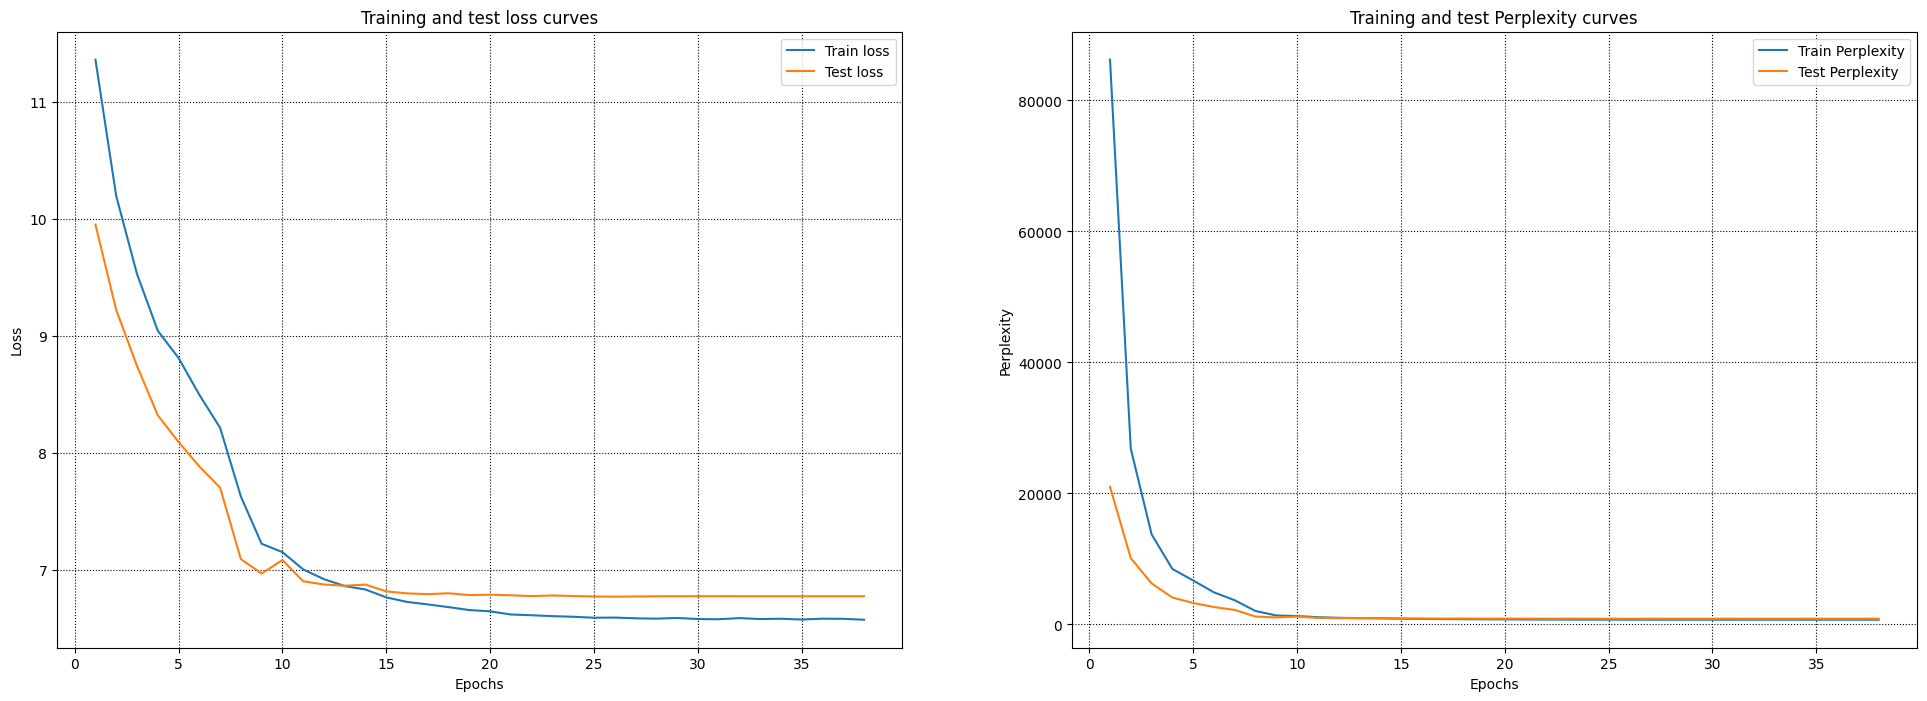

In [ ]:
plot_train_progress(train_losses[2:], val_losses[2:], train_perplexities[2:], val_perplexities[2:], 38)

Function to generate sequence:

In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, device, seed=None):
    """
    Generate sequence using LSTM model

    """
    if seed is not None:
        torch.manual_seed(seed)
    model.eval()
    if prompt is None:
      indices = [random.randint(0, len(vocab)-1)]
    else:
      tokens = tokenizer(prompt)
      indices = [vocab[t] for t in tokens]
    batch_size = 1
    hidden = model.init_hidden(batch_size, device)
    with torch.inference_mode():
        for i in range(max_seq_len):
            src = torch.LongTensor([indices]).to(device)
            prediction, hidden = model(src, hidden)
            probs = torch.softmax(prediction[:, -1] / temperature, dim=-1).squeeze()

            #prediction = torch.multinomial(probs, num_samples=3).squeeze()
            prediction = torch.multinomial(probs, num_samples=1).item()
            #prediction = prediction[random.randint(0, 2)]
            while prediction == vocab['<unk>']:
                prediction = torch.multinomial(probs, num_samples=1).item()

            if prediction == vocab['</s>']:
                break

            indices.append(prediction)

    itos = vocab.get_itos()
    tokens = [itos[i] for i in indices]
    return tokens

Generating sequences with initial prompt and with different temperatures:

In [ ]:
prompt = 'The queen'
max_seq_len = 20
#seed = 0

temperatures = [1.0, 1.3, 1.6, 2.0]
for temperature in temperatures:
    generation = generate(prompt, max_seq_len, temperature, lstm_model, tokenizer,
                          vocab, device)
    print("Temperature: "  +str(temperature)+'\n'+' '.join(generation)+'\n')

Temperature: 1.0
the queen then were thee

Temperature: 1.3
the queen you

Temperature: 1.6
the queen in possible maid he ourself honest the woman an chin her rest like last banished although clothe gentle she urge

Temperature: 2.0
the queen you gloss aid alcides gillian ajax laugh fortitude continuer nay sever with condemnation by as lesser performers lads most rode



Generating 10 sequences without initial prompts:

In [ ]:
prompt = None
max_seq_len = 15
#seed = 0
gen_count = 10
temperature = 2

for _ in range(gen_count):
    generation = generate(prompt, max_seq_len, temperature, lstm_model, tokenizer,
                          vocab, device)
    print(' '.join(generation)+'\n')

faites is bans canst entreaties plainness bind command

unmanner to forth emperor affairs scorns must amber ill requital moral grow speeches goddess yesterday fenton

carries thou purses loves to curs fitness chooses physic night oh than poins gust general mell

testimonies welcome only parents niggardly loyal casca we judgment aufidius creature intend than richmond dues pound

quicksand if prayers going you territories fiends council blemish translate admittance dukes city tarrying great giddily

unmaster articles his belike afterwards any preparation watch forth woeful beauteous which farther poor would model

turf quote melancholy saturnine give corioli sighs basilisks farewell worshipped refused woo summit shame trebles chiron

strip and serve have no exceed when way lies yes stol eyes grief may distant prize

carriage

apprehensive mercy might a land has o abide despite that slow nut jerkin committed the gate



From my point of view, these generated sequences are worse than those got from the n-grams model. I assume this is caused by some mistakes in the implementation of the model or generating function. Could be improved later.

### Unsuccessful experiment with the feed-forward NN

First I tried to create language model based on feed-forward neural network.

Data preparation for using in feed-forward model:

In [ ]:
%%time
seqs = []
for i in sticked_sents:
  seqs.append(create_seq(i, N))

# merge list-of-lists into a single list
seqs = sum(seqs, [])

# count of sequences
len(seqs)

In [ ]:
# create inputs and targets (x and y)
X = []
y = []

for s in seqs:
  X.append(" ".join(s.split()[:-1]))
  y.append("".join(s.split()[-1]))

In [ ]:
X[:5], y[:5]

(['before we proceed any further hear',
  'we proceed any further hear me',
  'proceed any further hear me speak',
  'any further hear me speak </s>',
  'further hear me speak </s> speak'],
 ['me', 'speak', '</s>', 'speak', 'speak'])

In [ ]:
len(X), len(y)

(841358, 841358)

In [ ]:
def corpus_padding(texts, sequence_length):
  if isinstance(texts[0], list):
    features=np.ones((len(texts), sequence_length), dtype=int)
    for i, review in enumerate(texts):
      review_len=len(review)
      if (review_len<=sequence_length):
        pad=list(np.ones(sequence_length-review_len))
        new=pad+review
      else:
        new=review[:sequence_length]
      features[i,:]=np.array(new)
  else:

    review_len=len(texts)
    if (review_len<=sequence_length):
      pad=list(np.ones(sequence_length-review_len))
      features=pad+texts
    else:
      new=review[:sequence_length]
      features=np.array(new)
  return features

In [ ]:
padded_seqs = corpus_padding(encoded_seqs, N+1)

In [ ]:
padded_seqs[:15]

array([[   2,  144,   36, 1016,  124,  423,  119],
       [ 144,   36, 1016,  124,  423,  119,   17],
       [  36, 1016,  124,  423,  119,   17,  103],
       [1016,  124,  423,  119,   17,  103,    3],
       [ 124,  423,  119,   17,  103,    3,    2],
       [ 423,  119,   17,  103,    3,    2,  103],
       [ 119,   17,  103,    3,    2,  103,  103],
       [  17,  103,    3,    2,  103,  103,    3],
       [ 103,    3,    2,  103,  103,    3,    2],
       [   3,    2,  103,  103,    3,    2,   10],
       [   2,  103,  103,    3,    2,   10,   43],
       [ 103,  103,    3,    2,   10,   43,   40],
       [ 103,    3,    2,   10,   43,   40, 1528],
       [   3,    2,   10,   43,   40, 1528,  289],
       [   2,   10,   43,   40, 1528,  289,    7]])

In [ ]:
# create inputs and targets (x and y)
X_int = []
y_int = []

for s in padded_seqs:
  X_int.append(s[:-1])
  y_int.append(s[-1])

In [ ]:
X_int[:6], y_int[:6]

([array([   2,  144,   36, 1016,  124,  423]),
  array([ 144,   36, 1016,  124,  423,  119]),
  array([  36, 1016,  124,  423,  119,   17]),
  array([1016,  124,  423,  119,   17,  103]),
  array([124, 423, 119,  17, 103,   3]),
  array([423, 119,  17, 103,   3,   2])],
 [119, 17, 103, 3, 2, 103])

In [ ]:
len(X_int), len(y_int)

(841358, 841358)

In [ ]:
class SeqDataset(Dataset):
    """Tfidf vectorized dataset."""

    def __init__(self, context, word):
        self.context = context
        self.word = word


    def __len__(self):
        return len(self.context)

    def __getitem__(self, i):
      return (torch.tensor(self.context[i]), torch.tensor(self.word[i], dtype=torch.long))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_int, y_int, test_size=.2, shuffle=True)

In [ ]:
train_ds = SeqDataset(X_train, y_train)
test_ds = SeqDataset(X_test, y_test)

In [ ]:
len(train_ds), len(test_ds)

(673086, 168272)

Defining DataLoaders:

In [ ]:
#dataloader
batch_size = 500
train_loader=DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader=DataLoader(test_ds, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Model definition:

In [ ]:
class FFLanguageModel(nn.Module):
    def __init__(self, v_size, embedding_dim, batch_size, context_size, hidden_size):
        super(FFLanguageModel, self).__init__()
        self.dims = embedding_dim  # embedding dimensions
        self.context_size = context_size
        self.embedding = nn.Embedding(v_size, self.dims)
        self.L1 = nn.Linear(self.dims * self.context_size, hidden_size)
        self.L2 = nn.Linear(hidden_size, v_size)
        self.relu = nn.ReLU()


    def forward(self, x):
        proj = self.embedding(x).view((batch_size, 1, -1)) # row vector.
        a1 = self.relu(self.L1(proj))
        a2 = self.L2(a1)
        return a2

In [ ]:
hidden_size = 2048
batch_size=2000
emb_dim = 20
N = 5

ff_model = FFLanguageModel(vocab_size, emb_dim, batch_size, N, hidden_size).to(device)

In [ ]:
from torchinfo import summary
summary(ff_model, (2000, 6,), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
FFLanguageModel                          [2000, 1, 21456]          --
├─Embedding: 1-1                         [2000, 6, 20]             429,120
├─Linear: 1-2                            [2000, 1, 2048]           247,808
├─ReLU: 1-3                              [2000, 1, 2048]           --
├─Linear: 1-4                            [2000, 1, 21456]          43,963,344
Total params: 44,640,272
Trainable params: 44,640,272
Non-trainable params: 0
Total mult-adds (G): 89.28
Input size (MB): 0.10
Forward/backward pass size (MB): 377.98
Params size (MB): 178.56
Estimated Total Size (MB): 556.64

In [ ]:
lr=0.01

optimizer = torch.optim.Adam(ff_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Train loop:

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    counter = 0
    print_every = 100

    for inputs, labels in tqdm(iterator, total = len(iterator)):
        inputs = inputs.type(torch.LongTensor).to(device)
        labels = labels.type(torch.LongTensor).to(device)
        counter += 1
        optimizer.zero_grad()

        y_logits = model(inputs).squeeze()
        probs = torch.softmax(y_logits, dim=0)

        predictions = torch.argmax(probs, axis=1)
        #print(predictions.shape, labels.shape)

        loss = criterion(probs.squeeze(), labels.squeeze())

        acc = accuracy(predictions, labels)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        if counter % print_every == 0:
          print(f"Batches: {counter*print_every}, Loss: {loss.item()}, Accuracy: {acc.item()}")
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Test loop:

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.inference_mode():
        for inputs, labels  in iterator:
            inputs = inputs.type(torch.LongTensor).to(device)
            labels = labels.type(torch.LongTensor).to(device)

            y_logits = model(inputs).squeeze()
            probs = torch.softmax(y_logits, dim=0)

            predictions = torch.argmax(probs, axis=1)

            loss = criterion(probs.squeeze(), labels)
            acc = accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The function performing all model's training process:

In [ ]:
def run_train(epochs, model, train_iterator, valid_iterator, optimizer, criterion, model_type):
    best_valid_loss = float('inf')
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    for epoch in range(epochs):

        # train the model
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # evaluate the model
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        val_losses.append(valid_loss)
        val_accs.append(valid_acc)

        # save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'saved_weights'+'_'+model_type+'.pt')


        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f} | Test loss: {valid_loss:.5f}, Test acc: {valid_acc:.2f}")

    return train_losses, val_losses, train_accs, val_accs

Training:

In [ ]:
model_type = 'Feed-Forward'
num_epochs = 100
tr_loss, tst_loss, tr_acc, tst_acc = run_train(num_epochs, ff_model, train_loader,  test_loader, optimizer, criterion, model_type)

  0%|          | 0/3365 [00:00<?, ?it/s]

Batches: 10000, Loss: 9.968769073486328, Accuracy: 0.0
Batches: 20000, Loss: 9.9630126953125, Accuracy: 0.004999999888241291
Batches: 30000, Loss: 9.963478088378906, Accuracy: 0.0
Batches: 40000, Loss: 9.969352722167969, Accuracy: 0.0
Batches: 50000, Loss: 9.96451187133789, Accuracy: 0.004999999888241291
Batches: 60000, Loss: 9.952775955200195, Accuracy: 0.009999999776482582
Batches: 70000, Loss: 9.959524154663086, Accuracy: 0.0
Batches: 80000, Loss: 9.955351829528809, Accuracy: 0.014999999664723873
Batches: 90000, Loss: 9.965023040771484, Accuracy: 0.009999999776482582
Batches: 100000, Loss: 9.966109275817871, Accuracy: 0.0
Batches: 110000, Loss: 9.961374282836914, Accuracy: 0.009999999776482582
Batches: 120000, Loss: 9.95666217803955, Accuracy: 0.009999999776482582
Batches: 130000, Loss: 9.96998119354248, Accuracy: 0.0
Batches: 140000, Loss: 9.977008819580078, Accuracy: 0.004999999888241291
Batches: 150000, Loss: 9.96691608428955, Accuracy: 0.014999999664723873
Batches: 160000, Loss:

  0%|          | 0/3365 [00:00<?, ?it/s]

Batches: 10000, Loss: 9.95213794708252, Accuracy: 0.004999999888241291
Batches: 20000, Loss: 9.932071685791016, Accuracy: 0.019999999552965164
Batches: 30000, Loss: 9.962039947509766, Accuracy: 0.009999999776482582
Batches: 40000, Loss: 9.962106704711914, Accuracy: 0.004999999888241291
Batches: 50000, Loss: 9.934349060058594, Accuracy: 0.014999999664723873
Batches: 60000, Loss: 9.96084213256836, Accuracy: 0.009999999776482582
Batches: 70000, Loss: 9.957094192504883, Accuracy: 0.019999999552965164
Batches: 80000, Loss: 9.9568510055542, Accuracy: 0.014999999664723873
Batches: 90000, Loss: 9.962143898010254, Accuracy: 0.009999999776482582
Batches: 100000, Loss: 9.961864471435547, Accuracy: 0.004999999888241291
Batches: 110000, Loss: 9.947035789489746, Accuracy: 0.009999999776482582
Batches: 120000, Loss: 9.94217300415039, Accuracy: 0.014999999664723873
Batches: 130000, Loss: 9.966896057128906, Accuracy: 0.014999999664723873
Batches: 140000, Loss: 9.956884384155273, Accuracy: 0.01499999966

  0%|          | 0/3365 [00:00<?, ?it/s]

Batches: 10000, Loss: 9.956565856933594, Accuracy: 0.019999999552965164
Batches: 20000, Loss: 9.957003593444824, Accuracy: 0.014999999664723873
Batches: 30000, Loss: 9.951976776123047, Accuracy: 0.014999999664723873
Batches: 40000, Loss: 9.931764602661133, Accuracy: 0.009999999776482582
Batches: 50000, Loss: 9.952118873596191, Accuracy: 0.009999999776482582
Batches: 60000, Loss: 9.960164070129395, Accuracy: 0.009999999776482582
Batches: 70000, Loss: 9.944433212280273, Accuracy: 0.019999999552965164
Batches: 80000, Loss: 9.961767196655273, Accuracy: 0.019999999552965164
Batches: 90000, Loss: 9.965005874633789, Accuracy: 0.004999999888241291
Batches: 100000, Loss: 9.962067604064941, Accuracy: 0.014999999664723873
Batches: 110000, Loss: 9.958329200744629, Accuracy: 0.014999999664723873
Batches: 120000, Loss: 9.96713638305664, Accuracy: 0.009999999776482582
Batches: 130000, Loss: 9.957006454467773, Accuracy: 0.014999999664723873
Batches: 140000, Loss: 9.967046737670898, Accuracy: 0.0099999

  0%|          | 0/3365 [00:00<?, ?it/s]

Batches: 10000, Loss: 9.951983451843262, Accuracy: 0.019999999552965164
Batches: 20000, Loss: 9.961915016174316, Accuracy: 0.009999999776482582
Batches: 30000, Loss: 9.964256286621094, Accuracy: 0.004999999888241291
Batches: 40000, Loss: 9.94669246673584, Accuracy: 0.019999999552965164
Batches: 50000, Loss: 9.961801528930664, Accuracy: 0.009999999776482582
Batches: 60000, Loss: 9.94702434539795, Accuracy: 0.014999999664723873
Batches: 70000, Loss: 9.951998710632324, Accuracy: 0.014999999664723873
Batches: 80000, Loss: 9.956695556640625, Accuracy: 0.009999999776482582
Batches: 90000, Loss: 9.957015991210938, Accuracy: 0.009999999776482582
Batches: 100000, Loss: 9.95700454711914, Accuracy: 0.009999999776482582
Batches: 110000, Loss: 9.951933860778809, Accuracy: 0.009999999776482582
Batches: 120000, Loss: 9.957097053527832, Accuracy: 0.009999999776482582
Batches: 130000, Loss: 9.960029602050781, Accuracy: 0.009999999776482582
Batches: 140000, Loss: 9.966768264770508, Accuracy: 0.004999999

  0%|          | 0/3365 [00:00<?, ?it/s]

Batches: 10000, Loss: 9.952052116394043, Accuracy: 0.004999999888241291
Batches: 20000, Loss: 9.969344139099121, Accuracy: 0.004999999888241291
Batches: 30000, Loss: 9.962076187133789, Accuracy: 0.004999999888241291
Batches: 40000, Loss: 9.95048999786377, Accuracy: 0.014999999664723873
Batches: 50000, Loss: 9.947039604187012, Accuracy: 0.019999999552965164
Batches: 60000, Loss: 9.962081909179688, Accuracy: 0.004999999888241291
Batches: 70000, Loss: 9.952042579650879, Accuracy: 0.014999999664723873
Batches: 80000, Loss: 9.962078094482422, Accuracy: 0.009999999776482582
Batches: 90000, Loss: 9.967013359069824, Accuracy: 0.014999999664723873
Batches: 100000, Loss: 9.966946601867676, Accuracy: 0.004999999888241291
Batches: 110000, Loss: 9.957080841064453, Accuracy: 0.0
Batches: 120000, Loss: 9.956863403320312, Accuracy: 0.009999999776482582
Batches: 130000, Loss: 9.967097282409668, Accuracy: 0.0
Batches: 140000, Loss: 9.962035179138184, Accuracy: 0.004999999888241291
Batches: 150000, Loss:

  0%|          | 0/3365 [00:00<?, ?it/s]

Batches: 10000, Loss: 9.954445838928223, Accuracy: 0.004999999888241291
Batches: 20000, Loss: 9.962240219116211, Accuracy: 0.009999999776482582
Batches: 30000, Loss: 9.967113494873047, Accuracy: 0.004999999888241291
Batches: 40000, Loss: 9.971983909606934, Accuracy: 0.009999999776482582
Batches: 50000, Loss: 9.957075119018555, Accuracy: 0.009999999776482582
Batches: 60000, Loss: 9.962059020996094, Accuracy: 0.004999999888241291
Batches: 70000, Loss: 9.956830024719238, Accuracy: 0.004999999888241291
Batches: 80000, Loss: 9.96707820892334, Accuracy: 0.009999999776482582
Batches: 90000, Loss: 9.956841468811035, Accuracy: 0.014999999664723873
Batches: 100000, Loss: 9.954983711242676, Accuracy: 0.014999999664723873
Batches: 110000, Loss: 9.972077369689941, Accuracy: 0.009999999776482582
Batches: 120000, Loss: 9.962055206298828, Accuracy: 0.004999999888241291
Batches: 130000, Loss: 9.956981658935547, Accuracy: 0.004999999888241291
Batches: 140000, Loss: 9.969414710998535, Accuracy: 0.0049999

  0%|          | 0/3365 [00:00<?, ?it/s]

Batches: 10000, Loss: 9.972058296203613, Accuracy: 0.004999999888241291
Batches: 20000, Loss: 9.957076072692871, Accuracy: 0.009999999776482582
Batches: 30000, Loss: 9.961668014526367, Accuracy: 0.004999999888241291
Batches: 40000, Loss: 9.951882362365723, Accuracy: 0.014999999664723873
Batches: 50000, Loss: 9.966888427734375, Accuracy: 0.009999999776482582
Batches: 60000, Loss: 9.95692253112793, Accuracy: 0.009999999776482582
Batches: 70000, Loss: 9.956799507141113, Accuracy: 0.014999999664723873
Batches: 80000, Loss: 9.952091217041016, Accuracy: 0.014999999664723873
Batches: 90000, Loss: 9.966846466064453, Accuracy: 0.009999999776482582
Batches: 100000, Loss: 9.967077255249023, Accuracy: 0.0
Batches: 110000, Loss: 9.959429740905762, Accuracy: 0.014999999664723873
Batches: 120000, Loss: 9.966991424560547, Accuracy: 0.009999999776482582
Batches: 130000, Loss: 9.971794128417969, Accuracy: 0.0
Batches: 140000, Loss: 9.966940879821777, Accuracy: 0.004999999888241291
Batches: 150000, Loss:

  0%|          | 0/3365 [00:00<?, ?it/s]

Batches: 10000, Loss: 9.957003593444824, Accuracy: 0.009999999776482582
Batches: 20000, Loss: 9.956969261169434, Accuracy: 0.014999999664723873
Batches: 30000, Loss: 9.956999778747559, Accuracy: 0.019999999552965164
Batches: 40000, Loss: 9.951910972595215, Accuracy: 0.019999999552965164
Batches: 50000, Loss: 9.971936225891113, Accuracy: 0.004999999888241291
Batches: 60000, Loss: 9.949461936950684, Accuracy: 0.014999999664723873
Batches: 70000, Loss: 9.951947212219238, Accuracy: 0.019999999552965164
Batches: 80000, Loss: 9.958333969116211, Accuracy: 0.009999999776482582
Batches: 90000, Loss: 9.957056999206543, Accuracy: 0.004999999888241291
Batches: 100000, Loss: 9.951680183410645, Accuracy: 0.009999999776482582
Batches: 110000, Loss: 9.956948280334473, Accuracy: 0.014999999664723873
Batches: 120000, Loss: 9.966968536376953, Accuracy: 0.004999999888241291
Batches: 130000, Loss: 9.956968307495117, Accuracy: 0.014999999664723873
Batches: 140000, Loss: 9.977059364318848, Accuracy: 0.004999

  0%|          | 0/3365 [00:00<?, ?it/s]

Batches: 10000, Loss: 9.966898918151855, Accuracy: 0.009999999776482582
Batches: 20000, Loss: 9.951922416687012, Accuracy: 0.004999999888241291
Batches: 30000, Loss: 9.977004051208496, Accuracy: 0.004999999888241291
Batches: 40000, Loss: 9.96188735961914, Accuracy: 0.004999999888241291
Batches: 50000, Loss: 9.961725234985352, Accuracy: 0.014999999664723873
Batches: 60000, Loss: 9.946508407592773, Accuracy: 0.014999999664723873
Batches: 70000, Loss: 9.971663475036621, Accuracy: 0.009999999776482582
Batches: 80000, Loss: 9.964458465576172, Accuracy: 0.009999999776482582
Batches: 90000, Loss: 9.956872940063477, Accuracy: 0.009999999776482582
Batches: 100000, Loss: 9.96180248260498, Accuracy: 0.009999999776482582
Batches: 110000, Loss: 9.961915016174316, Accuracy: 0.014999999664723873
Batches: 120000, Loss: 9.966882705688477, Accuracy: 0.014999999664723873
Batches: 130000, Loss: 9.966889381408691, Accuracy: 0.004999999888241291
Batches: 140000, Loss: 9.962084770202637, Accuracy: 0.00999999

  0%|          | 0/3365 [00:00<?, ?it/s]

Batches: 10000, Loss: 9.946965217590332, Accuracy: 0.014999999664723873
Batches: 20000, Loss: 9.956918716430664, Accuracy: 0.009999999776482582
Batches: 30000, Loss: 9.966854095458984, Accuracy: 0.004999999888241291
Batches: 40000, Loss: 9.96707820892334, Accuracy: 0.009999999776482582
Batches: 50000, Loss: 9.96653938293457, Accuracy: 0.009999999776482582
Batches: 60000, Loss: 9.942004203796387, Accuracy: 0.009999999776482582
Batches: 70000, Loss: 9.959027290344238, Accuracy: 0.019999999552965164
Batches: 80000, Loss: 9.952009201049805, Accuracy: 0.014999999664723873
Batches: 90000, Loss: 9.972002029418945, Accuracy: 0.004999999888241291
Batches: 100000, Loss: 9.966744422912598, Accuracy: 0.009999999776482582
Batches: 110000, Loss: 9.958340644836426, Accuracy: 0.014999999664723873
Batches: 120000, Loss: 9.954259872436523, Accuracy: 0.009999999776482582
Batches: 130000, Loss: 9.961910247802734, Accuracy: 0.0
Batches: 140000, Loss: 9.956939697265625, Accuracy: 0.014999999664723873
Batche

  0%|          | 0/3365 [00:00<?, ?it/s]

Batches: 10000, Loss: 9.951983451843262, Accuracy: 0.009999999776482582
Batches: 20000, Loss: 9.946702003479004, Accuracy: 0.014999999664723873
Batches: 30000, Loss: 9.97193431854248, Accuracy: 0.0
Batches: 40000, Loss: 9.966845512390137, Accuracy: 0.004999999888241291
Batches: 50000, Loss: 9.95695686340332, Accuracy: 0.019999999552965164
Batches: 60000, Loss: 9.958998680114746, Accuracy: 0.004999999888241291
Batches: 70000, Loss: 9.971650123596191, Accuracy: 0.0
Batches: 80000, Loss: 9.956560134887695, Accuracy: 0.009999999776482582
Batches: 90000, Loss: 9.95679759979248, Accuracy: 0.004999999888241291
Batches: 100000, Loss: 9.966856956481934, Accuracy: 0.014999999664723873
Batches: 110000, Loss: 9.966924667358398, Accuracy: 0.009999999776482582
Batches: 120000, Loss: 9.956953048706055, Accuracy: 0.009999999776482582
Batches: 130000, Loss: 9.976848602294922, Accuracy: 0.004999999888241291
Batches: 140000, Loss: 9.97657585144043, Accuracy: 0.004999999888241291
Batches: 150000, Loss: 9.

  0%|          | 0/3365 [00:00<?, ?it/s]

Batches: 10000, Loss: 9.951764106750488, Accuracy: 0.009999999776482582
Batches: 20000, Loss: 9.971954345703125, Accuracy: 0.004999999888241291
Batches: 30000, Loss: 9.966924667358398, Accuracy: 0.009999999776482582
Batches: 40000, Loss: 9.966835021972656, Accuracy: 0.004999999888241291
Batches: 50000, Loss: 9.971868515014648, Accuracy: 0.009999999776482582
Batches: 60000, Loss: 9.966486930847168, Accuracy: 0.004999999888241291
Batches: 70000, Loss: 9.97192668914795, Accuracy: 0.004999999888241291
Batches: 80000, Loss: 9.96686840057373, Accuracy: 0.004999999888241291
Batches: 90000, Loss: 9.961737632751465, Accuracy: 0.004999999888241291
Batches: 100000, Loss: 9.9568510055542, Accuracy: 0.009999999776482582
Batches: 110000, Loss: 9.961889266967773, Accuracy: 0.004999999888241291
Batches: 120000, Loss: 9.96692943572998, Accuracy: 0.014999999664723873
Batches: 130000, Loss: 9.946798324584961, Accuracy: 0.019999999552965164
Batches: 140000, Loss: 9.956862449645996, Accuracy: 0.00999999977

  0%|          | 0/3365 [00:00<?, ?it/s]

Batches: 10000, Loss: 9.971456527709961, Accuracy: 0.004999999888241291
Batches: 20000, Loss: 9.961695671081543, Accuracy: 0.009999999776482582
Batches: 30000, Loss: 9.96677017211914, Accuracy: 0.004999999888241291
Batches: 40000, Loss: 9.951926231384277, Accuracy: 0.019999999552965164
Batches: 50000, Loss: 9.95650863647461, Accuracy: 0.009999999776482582
Batches: 60000, Loss: 9.946674346923828, Accuracy: 0.009999999776482582
Batches: 70000, Loss: 9.971837997436523, Accuracy: 0.004999999888241291
Batches: 80000, Loss: 9.949552536010742, Accuracy: 0.009999999776482582
Batches: 90000, Loss: 9.946889877319336, Accuracy: 0.02499999850988388
Batches: 100000, Loss: 9.966862678527832, Accuracy: 0.014999999664723873
Batches: 110000, Loss: 9.964273452758789, Accuracy: 0.004999999888241291
Batches: 120000, Loss: 9.961841583251953, Accuracy: 0.009999999776482582
Batches: 130000, Loss: 9.959124565124512, Accuracy: 0.004999999888241291
Batches: 140000, Loss: 9.956757545471191, Accuracy: 0.004999999

  0%|          | 0/3365 [00:00<?, ?it/s]

Batches: 10000, Loss: 9.97177505493164, Accuracy: 0.004999999888241291
Batches: 20000, Loss: 9.956899642944336, Accuracy: 0.014999999664723873
Batches: 30000, Loss: 9.961960792541504, Accuracy: 0.004999999888241291
Batches: 40000, Loss: 9.966717720031738, Accuracy: 0.009999999776482582
Batches: 50000, Loss: 9.97177791595459, Accuracy: 0.004999999888241291
Batches: 60000, Loss: 9.951834678649902, Accuracy: 0.014999999664723873
Batches: 70000, Loss: 9.96636962890625, Accuracy: 0.004999999888241291
Batches: 80000, Loss: 9.961807250976562, Accuracy: 0.009999999776482582
Batches: 90000, Loss: 9.964818954467773, Accuracy: 0.009999999776482582
Batches: 100000, Loss: 9.966453552246094, Accuracy: 0.004999999888241291
Batches: 110000, Loss: 9.953341484069824, Accuracy: 0.014999999664723873
Batches: 120000, Loss: 9.966376304626465, Accuracy: 0.009999999776482582
Batches: 130000, Loss: 9.968915939331055, Accuracy: 0.009999999776482582
Batches: 140000, Loss: 9.96656322479248, Accuracy: 0.0099999997

KeyboardInterrupt: ignored

As we can see that the training of this model was unsuccessful - the loss was never reduced. Probably I have missed something or made some error in the train-test loop. Going to investigate it later.